In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

In [19]:
df.columns

Index(['stock_code', 'firm_name', 'year', 'month', 'establishment',
       'prefecture', 'indname_small', 'indname_large', 'yj_sales_growth',
       'yj_total_assets', 'yj_operating_cash_flow', 'yj_ros',
       'yj_cash_deposit_ratio', 'yj_leverage', 'yj_stock_price_growth',
       'yj_net_profit_growth', 'yj_firm_age', 'yj_fixed_assets_ratio',
       'yj_earthquake_dummy', 'lag_yj_sales_growth', 'lag_yj_total_assets',
       'lag_yj_operating_cash_flow', 'lag_yj_ros', 'lag_yj_cash_deposit_ratio',
       'lag_yj_leverage', 'lag_yj_stock_price_growth',
       'lag_yj_net_profit_growth', 'lag_yj_firm_age',
       'lag_yj_fixed_assets_ratio', 'lag_yj_earthquake_dummy',
       'earthquake_dummy', 'lag_earthquake_dummy', 'BCP'],
      dtype='object')

In [8]:
# データの読み込み
path = '../../data/Analysis/analysis_data_b.csv'
df = pd.read_csv(path, header=0, encoding='cp932')

X = df[[
    'lag_b_total_assets', 'lag_b_operating_cash_flow', 'lag_b_ros',
    'lag_b_cash_deposit_ratio', 'lag_b_leverage',
    'lag_b_stock_price_growth', 'lag_b_net_profit_growth', 'lag_b_firm_age',
    'lag_b_fixed_assets_ratio', 'lag_b_earthquake_dummy'
]]

# 群別変数Zを選択
Z = df['BCP']

# 傾向スコアの推定
const = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=Z, exog=const) # ロジスティック回帰
logit_res = logit_model.fit()

ps = logit_res.predict(const)
df['ps'] = ps
print('AUC = {:.3f}'.format(roc_auc_score(y_true=Z, y_score=ps)))
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.431801
         Iterations 7
AUC = 0.694
                           Logit Regression Results                           
Dep. Variable:                    BCP   No. Observations:                27352
Model:                          Logit   Df Residuals:                    27341
Method:                           MLE   Df Model:                           10
Date:                Mon, 11 Oct 2021   Pseudo R-squ.:                 0.07763
Time:                        02:32:30   Log-Likelihood:                -11811.
converged:                       True   LL-Null:                       -12805.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.3184      0.077    -43.089      0.

C:\Users\koeci\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


BCP
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

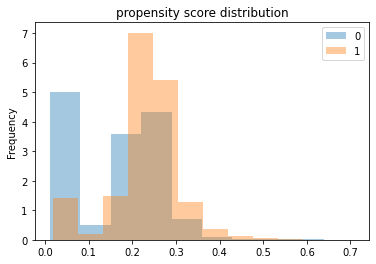

In [9]:
# 傾向スコアの分布を確認
ps_dist = df.groupby('BCP')['ps']
ps_dist.plot.hist(density=True, alpha=0.4, title=f'propensity score distribution', legend=True)

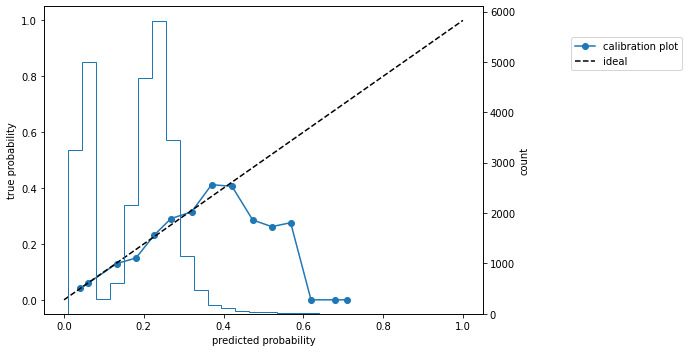

In [10]:
# calibration plot
fig, ax = plt.subplots(figsize=(10, 5))
prob_true, prob_pred = calibration_curve(y_true=Z, y_prob=ps, n_bins=20)
ax.plot(prob_pred, prob_true, marker='o', label='calibration plot')
ax.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
ax.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
ax.set_xlabel('predicted probability')
ax.set_ylabel('true probability')

ax2 = ax.twinx()
ax2.hist(ps, bins=20, histtype='step', rwidth=0.9)
ax2.set_ylabel('count')
plt.tight_layout()
plt.show()

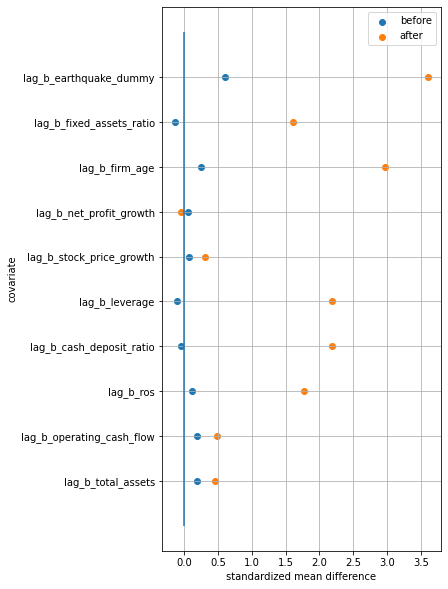

In [11]:
def standardized_mean_difference(X1, X0): # SMDを計算する関数
    N1 = len(X1)
    N0 = len(X0)
    s_pool = ((N1-1)*np.var(X1)+(N0-1)*np.var(X0))/(N1+N0-2)

    return (np.mean(X1)-np.mean(X0))/np.sqrt(s_pool)

def smd_on_the_treated(X, Z, ps): # 傾向スコアを用いた調整前後のSMDを計算する関数
    X1 = X[Z==1]
    X0 = X[Z==0]
    ps0 = ps[Z==0]
    X10 = X0*ps0/(1-ps0)

    smd_before = standardized_mean_difference(X1, X0)
    smd_after = standardized_mean_difference(X1, X10)

    return smd_before, smd_after

# 各共変量について、傾向スコアを用いた調整前後のSMDを計算する
smd_list = []
for name in X.columns:
    smd_before, smd_after = smd_on_the_treated(X=X[name], Z=Z, ps=ps)
    smd_list.append([name, smd_before, smd_after])
smd_df = pd.DataFrame(smd_list, columns=['covariate', 'SMD(before)', 'SMD(after)'])

# 各共変量について、傾向スコアを用いた調整前後のSMDをプロットする（love plotを作成する）
plt.figure(figsize=(5, 10))
plt.scatter(smd_df['SMD(before)'], smd_df['covariate'], label='before')
plt.scatter(smd_df['SMD(after)'], smd_df['covariate'], label='after')
plt.vlines([0], ymin=-1, ymax=X.shape[1])
plt.legend()
plt.xlabel('standardized mean difference')
plt.ylabel('covariate')
plt.grid(True)
plt.show()

In [4]:
df.columns

Index(['stock_code', 'firm_name', 'year', 'month', 'establishment',
       'prefecture', 'indname_small', 'indname_large', 'yj_sales_growth',
       'yj_total_assets', 'yj_operating_cash_flow', 'yj_ros',
       'yj_cash_deposit_ratio', 'yj_leverage', 'yj_stock_price_growth',
       'yj_net_profit_growth', 'yj_firm_age', 'yj_fixed_assets_ratio',
       'yj_earthquake_dummy', 'lag_yj_sales_growth', 'lag_yj_total_assets',
       'lag_yj_operating_cash_flow', 'lag_yj_ros', 'lag_yj_cash_deposit_ratio',
       'lag_yj_leverage', 'lag_yj_stock_price_growth',
       'lag_yj_net_profit_growth', 'lag_yj_firm_age',
       'lag_yj_fixed_assets_ratio', 'lag_yj_earthquake_dummy',
       'earthquake_dummy', 'lag_earthquake_dummy', 'BCP'],
      dtype='object')